<img src="https://s16353.pcdn.co/wp-content/uploads/2018/06/Churn.png" style="float: left;" width="400" height="100" />

 ## 1. Introduction

We aim to accomplist the following for this study:

1. Identify and visualize which factors contribute to customer churn:
    
2. Build a prediction model that will perform the following:
    * Classify if a customer is going to churn or not
    * Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn

## 2. Data set review & preparation

In this section we will seek to explore the structure of our data: 
1. To understand the input space the data set
2. And to prepare the sets for exploratory and prediction tasks as described in section 1

In [6]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [7]:
# Read the data frame
df = pd.read_csv('churn_train.txt', delimiter='\t')
df.shape

FileNotFoundError: [Errno 2] No such file or directory: 'churn_train.txt'

In [ ]:
# Read the data frame
df = pd.read_csv('churn_train.txt', delimiter='\t')
df.shape

In [3]:
df

NameError: name 'df' is not defined

In [4]:
# Get unique count for each variable
df.nunique()

NameError: name 'df' is not defined

In [5]:
# Drop the columns as explained above
df = df.drop(["region", "beh_score", "channel"], axis = 1)

NameError: name 'df' is not defined

In [ ]:
# Review the top rows of what is left of the data frame
df.head()

From the above, a couple of question linger:
1. The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
    * What date is it and of what relevance is this date
    * Would it be possible to obtain balances over a period of time as opposed to a single date.
2. There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?
3. What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?
4. A break down to the products bought into by a customer could provide more information topping listing of product count

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

In [ ]:
# Check variable data types
df.dtypes

### 3. Exploratory Data Analysis

Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

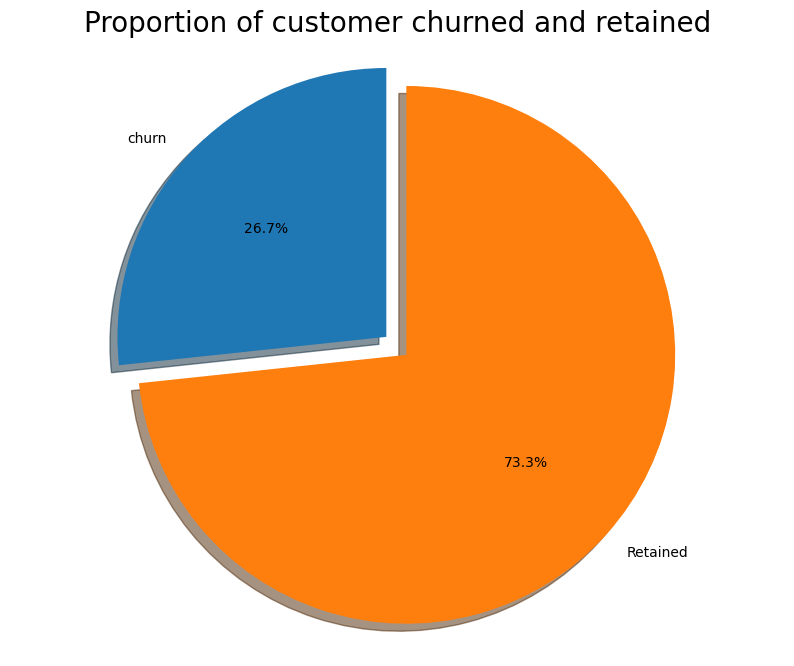

In [9]:
labels = 'churn', 'Retained'
sizes = [df.churn[df['churn']==1].count(), df.churn[df['churn']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 27% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn.
Given 26.7% is a small number,  we need to ensure that the chosen model does predict with great accuracy this 26.7% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

We note the following:
* Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.
* The proportion of female customers churning is also greater than that of male customers
* Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence. 
* Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.

<AxesSubplot:xlabel='churn', ylabel='total_products'>

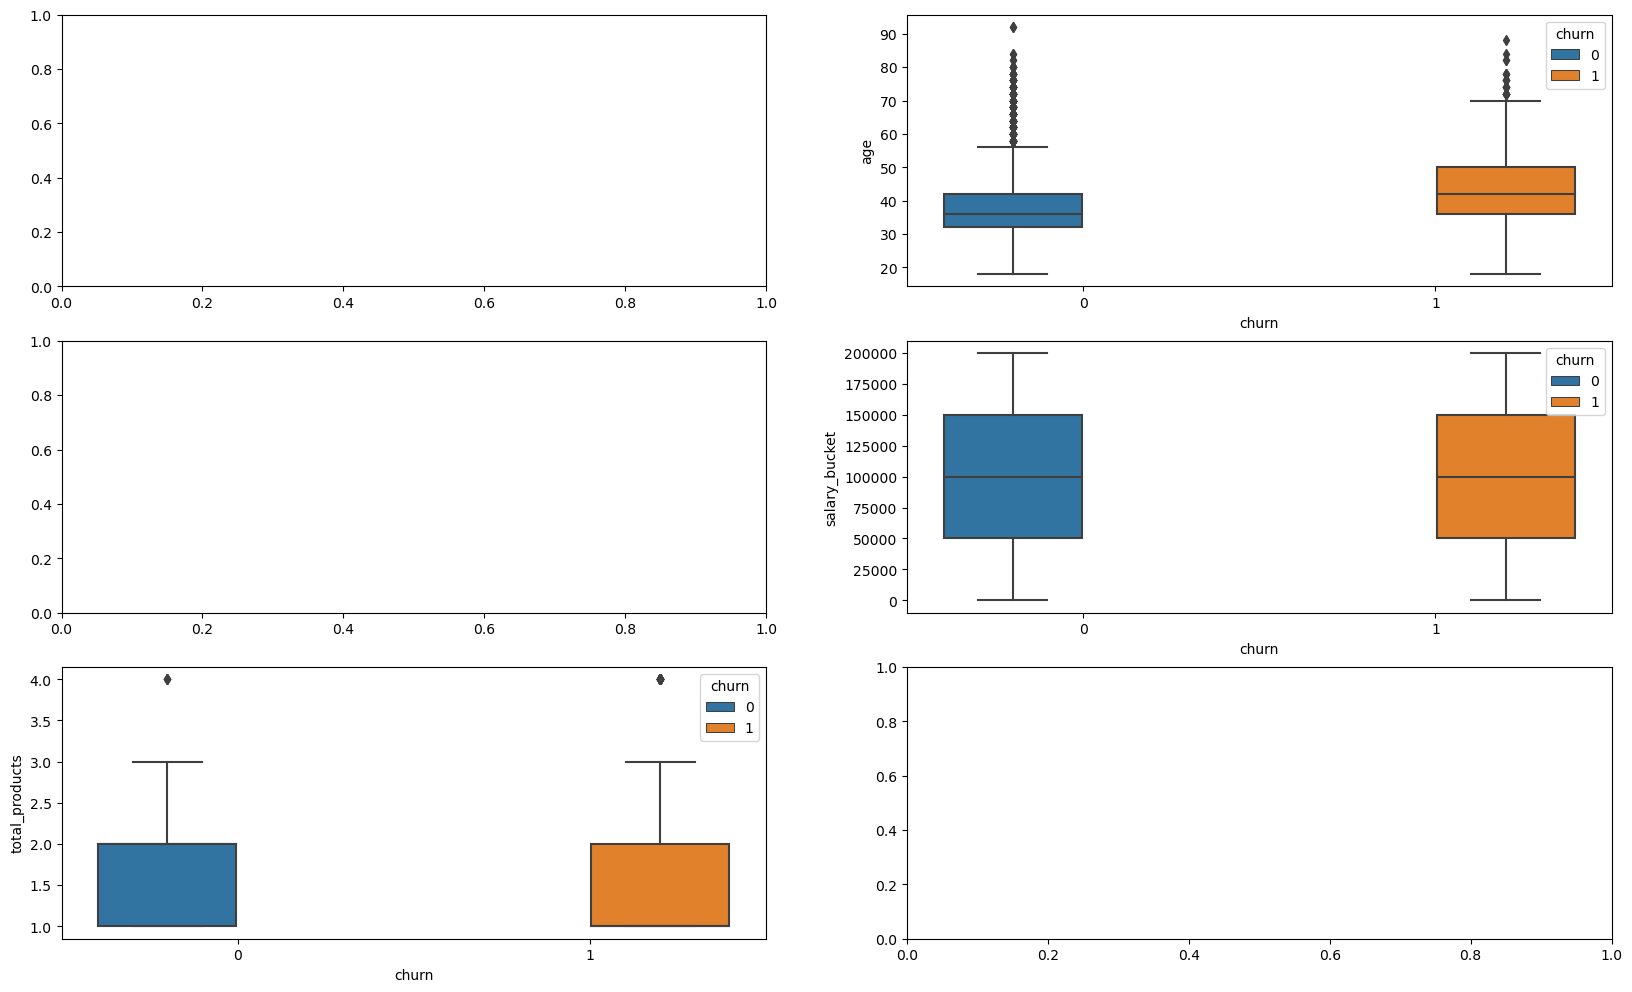

In [10]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='age',x = 'churn', hue = 'churn',data = df , ax=axarr[0][1])
sns.boxplot(y='salary_bucket',x = 'churn', hue = 'churn',data = df, ax=axarr[1][1])
sns.boxplot(y='total_products',x = 'churn', hue = 'churn',data = df, ax=axarr[2][0])

## 4. Feature engineering
We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

In [11]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

6644
1661


we have seen that the salary has little effect on the chance of a customer churning. However as seen above, the ratio of the bank balance and the estimated salary indicates that customers with a higher balance salary ratio churn more which would be worrying to the bank as this impacts their source of loan capital.

### 5. Model fitting and selection
For the model fitting, I will try out the following

Logistic regression in the primal space and with different kernels
SVM in the primal and with different Kernels
Ensemble models

In [12]:
# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [13]:
# Function to give best model score and parameters
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

In [14]:
df_train=df_train.fillna(0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6644 entries, 7571 to 7639
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            6644 non-null   int64  
 1   month_number         6644 non-null   int64  
 2   age                  6644 non-null   int64  
 3   lifetime             6644 non-null   int64  
 4   avg_transaction_sum  6644 non-null   int64  
 5   total_products       6644 non-null   int64  
 6   deposit              6644 non-null   int64  
 7   is_package           6644 non-null   int64  
 8   salary_bucket        6644 non-null   float64
 9   churn                6644 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 571.0 KB


In [15]:
# Fit primal logistic regression
param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],
              'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}

df_train = df_train.replace(np.inf, 0)

log_primal_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)

log_primal_Grid.fit(df_train.loc[:, df_train.columns != 'churn'], df_train.churn)

best_model(log_primal_Grid)

0.7301336171754687
{'C': 0.1, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
LogisticRegression(C=0.1, max_iter=250, tol=1e-05)


In [16]:
# Fit logistic regression with degree 2 polynomial kernel
param_grid = {'C': [0.1,10,50], 'max_iter': [300,500], 'fit_intercept':[True],'intercept_scaling':[1],'penalty':['l2'],
              'tol':[0.0001,0.000001]}
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'churn'])
log_pol2_Grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5, refit=True, verbose=0)
log_pol2_Grid.fit(df_train_pol2,df_train.churn)
best_model(log_pol2_Grid)

0.7406688832077746
{'C': 0.1, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 1e-06}
LogisticRegression(C=0.1, max_iter=300, solver='liblinear', tol=1e-06)


In [17]:
# Fit SVM with RBF Kernel
param_grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'churn'],df_train.churn)
best_model(SVM_grid)

0.7329921839474226
{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC(C=0.5, gamma=0.1, probability=True)


In [18]:
# Fit random forest classifier
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(df_train.loc[:, df_train.columns != 'churn'],df_train.churn)
best_model(RanFor_grid)

0.7832628482326598
{'max_depth': 6, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 50}
RandomForestClassifier(max_depth=6, max_features=4, min_samples_split=3,
                       n_estimators=50)


In [19]:
# Fit Extreme Gradient boosting classifier
param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(df_train.loc[:, df_train.columns != 'churn'],df_train.churn)
best_model(xgb_grid)

0.782210104526458
{'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 20}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


### Fit best Models

In [20]:
# Fit primal logistic regression
log_primal = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='multinomial',n_jobs=None, 
                                penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
log_primal.fit(df_train.loc[:, df_train.columns != 'churn'],df_train.churn)

LogisticRegression(C=100, max_iter=250, multi_class='multinomial', tol=1e-05)

In [21]:
# Fit logistic regression with pol 2 kernel
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'churn'])
log_pol2 = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=300, multi_class='multinomial', n_jobs=None, 
                              penalty='l2', random_state=None, solver='lbfgs',tol=0.0001, verbose=0, warm_start=False)
log_pol2.fit(df_train_pol2,df_train.churn)

LogisticRegression(C=10, max_iter=300, multi_class='multinomial')

In [22]:
# Fit SVM with RBF Kernel
SVM_RBF = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf', max_iter=-1, probability=True, 
              random_state=None, shrinking=True,tol=0.001, verbose=False)
SVM_RBF.fit(df_train.loc[:, df_train.columns != 'churn'],df_train.churn)

SVC(C=100, gamma=0.1, probability=True)

In [23]:
# Fit Random Forest classifier
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=8, max_features=6, max_leaf_nodes=None,min_impurity_decrease=0.0,
                            min_samples_leaf=1, min_samples_split=3,min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                            oob_score=False, random_state=None, verbose=0,warm_start=False)
RF.fit(df_train.loc[:, df_train.columns != 'churn'],df_train.churn)

RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3,
                       n_estimators=50)

### Review best model fit accuracy : Keen interest is on the performance in predicting 1's (Customers who churn)

In [24]:
print(classification_report(df_train.churn, log_primal.predict(df_train.loc[:, df_train.columns != 'churn'])))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      4870
           1       0.00      0.00      0.00      1774

    accuracy                           0.73      6644
   macro avg       0.37      0.50      0.42      6644
weighted avg       0.54      0.73      0.62      6644



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print(classification_report(df_train.churn,  log_pol2.predict(df_train_pol2)))

              precision    recall  f1-score   support

           0       0.74      0.99      0.84      4870
           1       0.44      0.03      0.06      1774

    accuracy                           0.73      6644
   macro avg       0.59      0.51      0.45      6644
weighted avg       0.66      0.73      0.63      6644



In [26]:
print(classification_report(df_train.churn,  SVM_RBF.predict(df_train.loc[:, df_train.columns != 'churn'])))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4870
           1       1.00      1.00      1.00      1774

    accuracy                           1.00      6644
   macro avg       1.00      1.00      1.00      6644
weighted avg       1.00      1.00      1.00      6644



In [27]:
print(classification_report(df_train.churn,  RF.predict(df_train.loc[:, df_train.columns != 'churn'])))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4870
           1       0.88      0.33      0.48      1774

    accuracy                           0.81      6644
   macro avg       0.84      0.66      0.68      6644
weighted avg       0.82      0.81      0.78      6644



In [28]:
y = df_train.churn
X = df_train.loc[:, df_train.columns != 'churn']
X_pol2 = df_train_pol2
auc_log_primal, fpr_log_primal, tpr_log_primal = get_auc_scores(y, log_primal.predict(X),log_primal.predict_proba(X)[:,1])
auc_log_pol2, fpr_log_pol2, tpr_log_pol2 = get_auc_scores(y, log_pol2.predict(X_pol2),log_pol2.predict_proba(X_pol2)[:,1])
auc_SVM_RBF, fpr_SVM_RBF, tpr_SVM_RBF = get_auc_scores(y, SVM_RBF.predict(X),SVM_RBF.predict_proba(X)[:,1])
auc_RF, fpr_RF, tpr_RF = get_auc_scores(y, RF.predict(X),RF.predict_proba(X)[:,1])

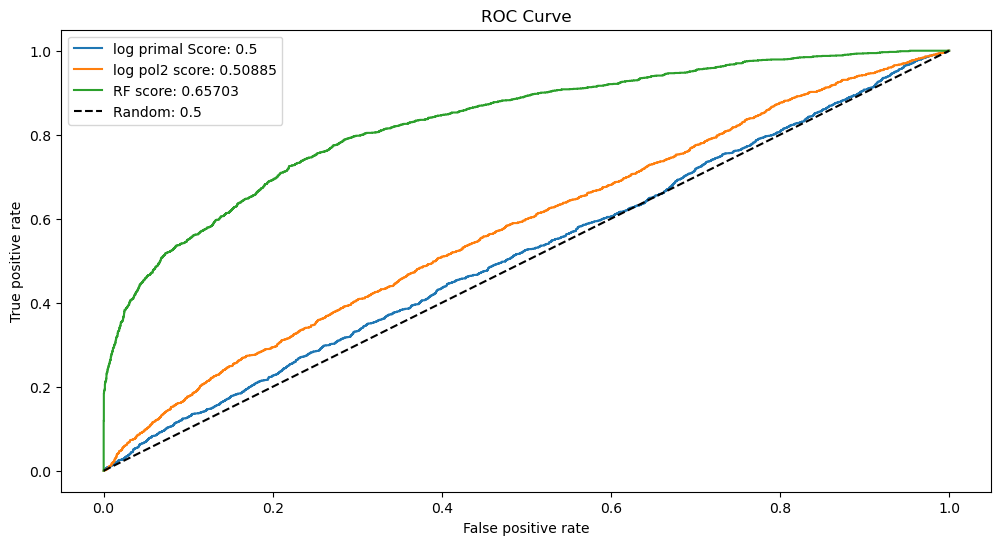

In [29]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_log_primal, tpr_log_primal, label = 'log primal Score: ' + str(round(auc_log_primal, 5)))
plt.plot(fpr_log_pol2, tpr_log_pol2, label = 'log pol2 score: ' + str(round(auc_log_pol2, 5)))
plt.plot(fpr_RF, tpr_RF, label = 'RF score: ' + str(round(auc_RF, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

### Test model prediction accuracy on test data

In [30]:
# Make the data transformation for test data
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

(1661, 10)

In [31]:
print(classification_report(df_test.churn,  RF.predict(df_test.loc[:, df_test.columns != 'churn'])))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      1219
           1       0.81      0.27      0.40       442

    accuracy                           0.79      1661
   macro avg       0.80      0.62      0.64      1661
weighted avg       0.79      0.79      0.75      1661



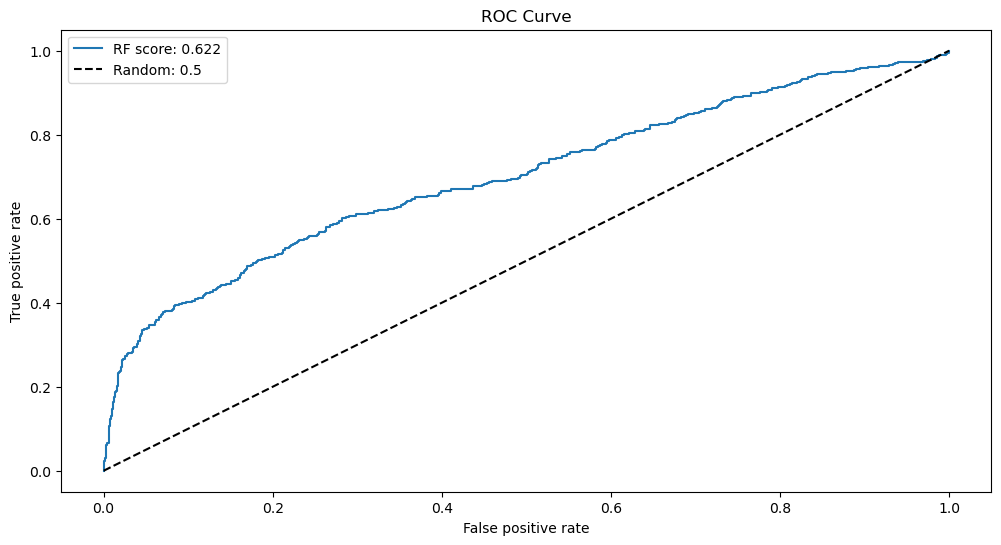

In [32]:
auc_RF_test, fpr_RF_test, tpr_RF_test = get_auc_scores(df_test.churn, RF.predict(df_test.loc[:, df_test.columns != 'churn']),
                                                       RF.predict_proba(df_test.loc[:, df_test.columns != 'churn'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF_test, tpr_RF_test, label = 'RF score: ' + str(round(auc_RF_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

### 6. Conclusion

The precision of the model on previousy unseen test data is slightly higher with regard to predicting 1's i.e. those customers that churn. However, in as much as the model has a high accuracy, it still misses about half of those who end up churning. This could be imprved by providing retraining the model with more data over time while in the meantime working with the model to save the 41% that would have churned :-)

In [1]:
!pip install pyaudio

     ---------------------------------------- 0.0/164.1 kB ? eta -:--:--
     ------- ------------------------------- 30.7/164.1 kB 1.4 MB/s eta 0:00:01
     -------------------------- ----------- 112.6/164.1 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 164.1/164.1 kB 1.1 MB/s eta 0:00:00
